In [1]:
!pip install mlflow -q

In [2]:
!pip install statsmodels -q

In [3]:
!pip cache purge

Files removed: 2 (160 kB)


In [4]:
import os
import joblib
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import mlflow
import mlflow.sklearn
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score


In [5]:
# Load the Boston Housing dataset
housing = fetch_california_housing()

# Create a DataFrame
hpdata = pd.DataFrame(housing.data, columns=housing.feature_names)
hpdata['PRICE'] = housing.target

In [6]:
# Save to CSV
hpdata.to_csv("data/hpdata.csv", index=False)

## EDA

In [7]:
os.makedirs('eda_outputs', exist_ok=True)

In [9]:
hpdata.head(2)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,PRICE
0,8.3252,41.0,6.984127,1.02381,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.97188,2401.0,2.109842,37.86,-122.22,3.585


In [8]:
hpdata.describe().T.to_csv(os.path.join('eda_outputs', "summary_stats.csv"))

In [9]:
def run_eda(data_path="data/hpdata.csv", out_dir ="eda_outputs"):
   os.makedirs(out_dir, exist_ok=True) 
   # Load dataset
   df = pd.read_csv(data_path)

   # Save summary to CSV 
   

In [10]:
print("Shape of Dataset\n", hpdata.shape)
print("\nMissing values sum\n",hpdata.isnull().sum())
print("\nInfo: ")
print(hpdata.info())


Shape of Dataset
 (20640, 9)

Missing values sum
 MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
PRICE         0
dtype: int64

Info: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   PRICE       20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB
None


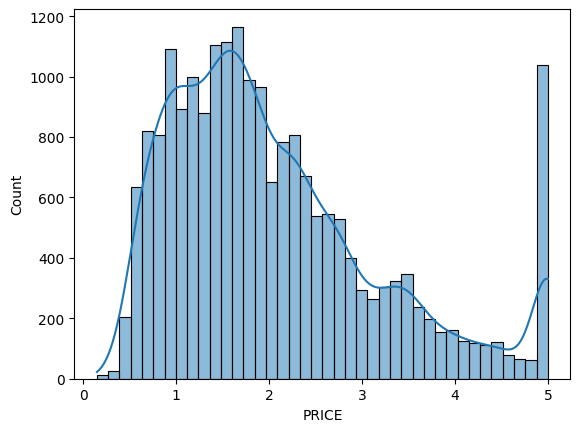

<Figure size 640x480 with 0 Axes>

In [11]:
# ----------- Target distribution ----------------

sns.histplot(hpdata['PRICE'], bins=40, kde=True)
plt.show()
plt.savefig(os.path.join('eda_outputs', "target_distribution.png"))

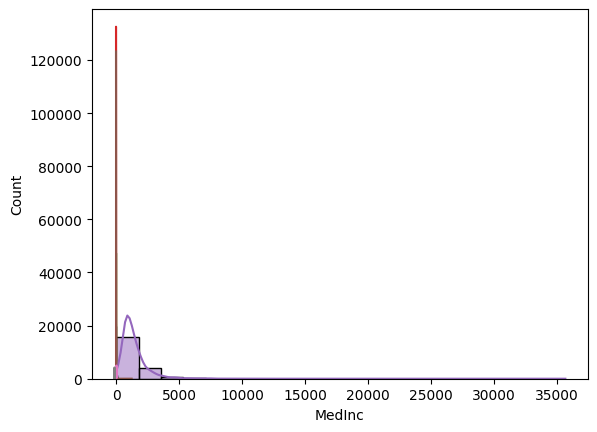

In [12]:
# ---------- Feature distribution-------------

for col in hpdata.drop(['PRICE'], axis=1):
    sns.histplot(hpdata[col], kde=True, bins=20)
    plt.figure(figsize=(12,8))
    plt.title(f"Distribution of {col}")
    plt.xlabel= col
    plt.savefig(os.path.join('eda_outputs', f"dist_{col}.png"))
    plt.close()

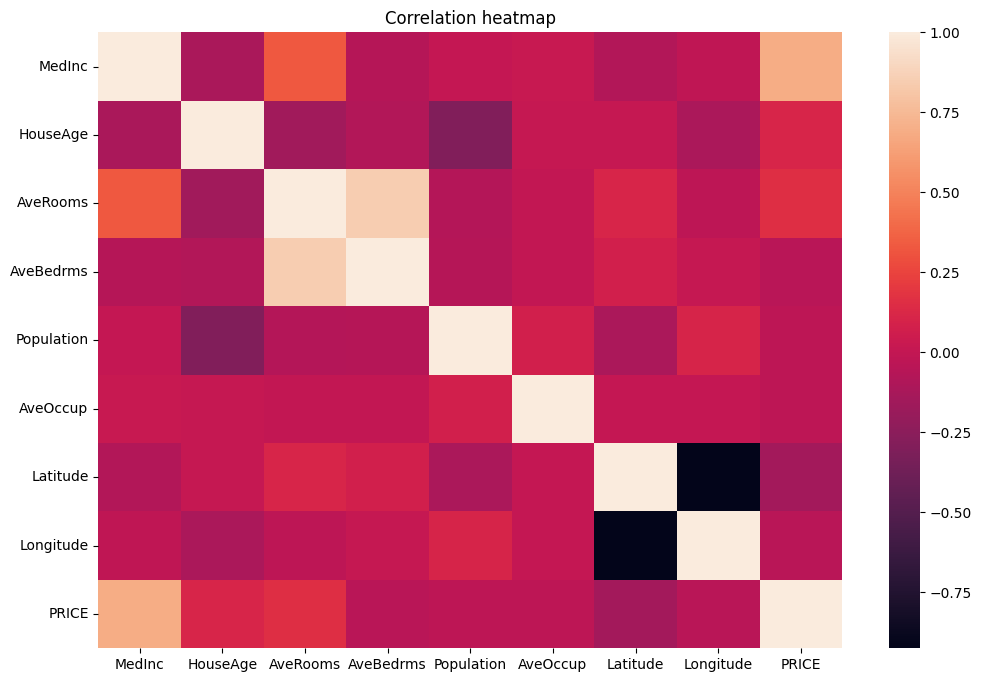

In [13]:
# ------- Correlation details -----
corr = hpdata.corr()
plt.figure(figsize=(12,8))
sns.heatmap(corr)
plt.title("Correlation heatmap")
plt.savefig(os.path.join('eda_outputs', "Corr_Heatmap.png"))


In [14]:
# ---- List of variables highly correlated in order ----
corr_target = corr["PRICE"].sort_values(ascending=False)
corr_target

PRICE         1.000000
MedInc        0.688075
AveRooms      0.151948
HouseAge      0.105623
AveOccup     -0.023737
Population   -0.024650
Longitude    -0.045967
AveBedrms    -0.046701
Latitude     -0.144160
Name: PRICE, dtype: float64

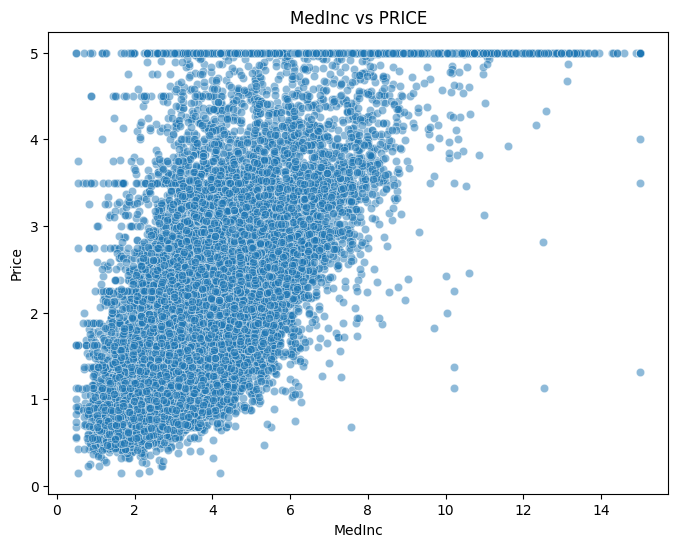

<Figure size 640x480 with 0 Axes>

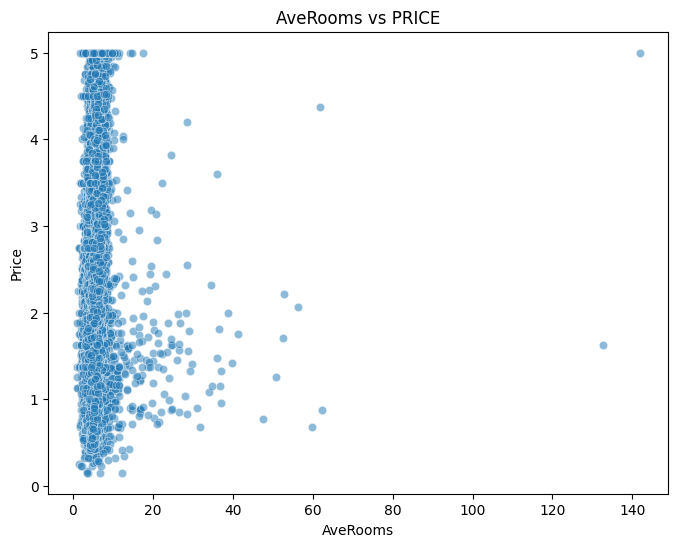

<Figure size 640x480 with 0 Axes>

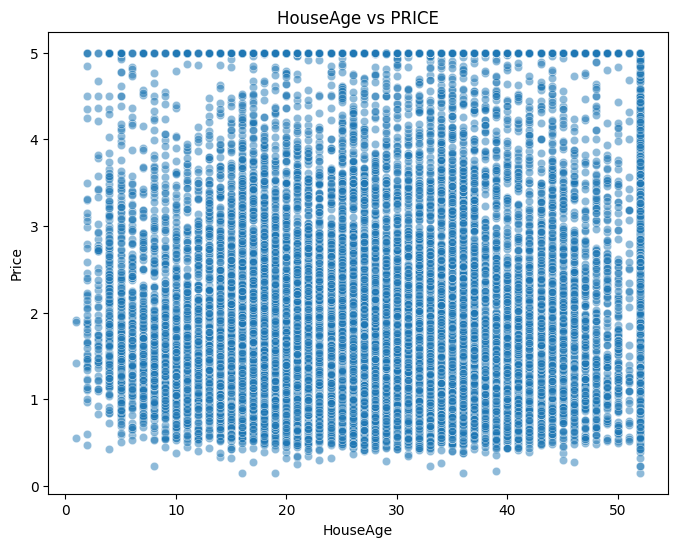

<Figure size 640x480 with 0 Axes>

In [15]:
# Feature vs Target scatter plots
# -------------------------
top_corr_features = corr["PRICE"].sort_values(ascending=False).index[1:4]  # top 3 features
for col in top_corr_features:
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=hpdata[col], y=hpdata["PRICE"], alpha=0.5)
    plt.title(f"{col} vs PRICE")
    plt.xlabel=col
    plt.ylabel("Price")
    plt.show()
    plt.savefig(os.path.join('eda_outputs', f"{col} Vs Target distribution.png"))

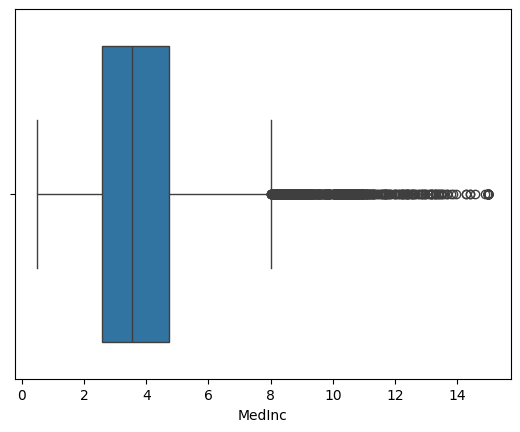

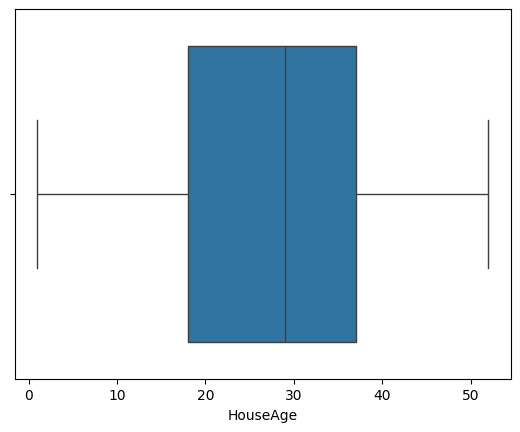

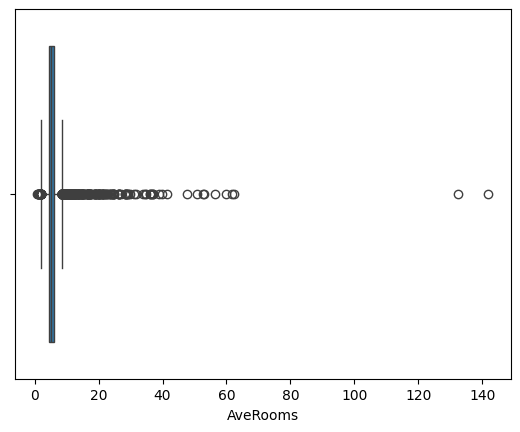

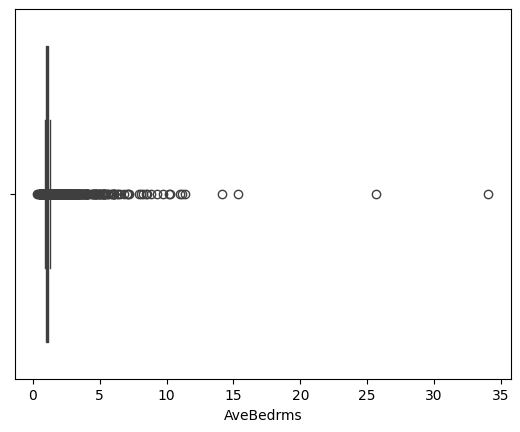

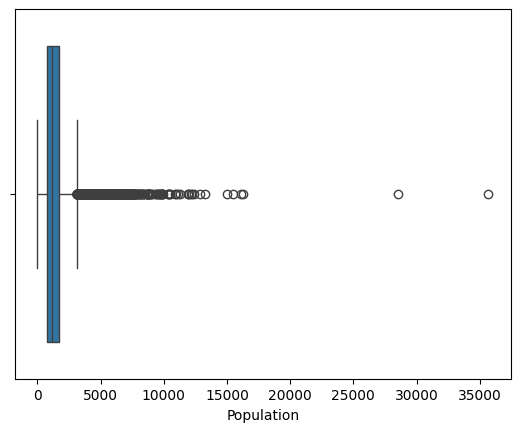

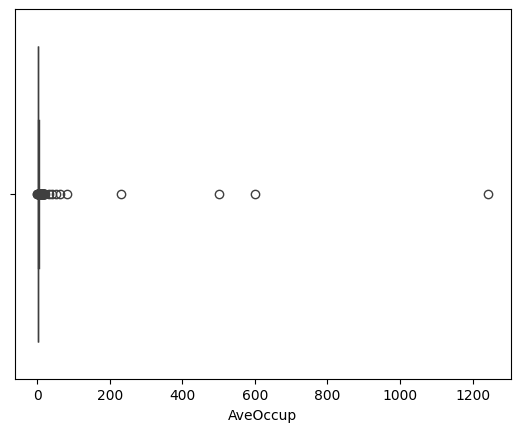

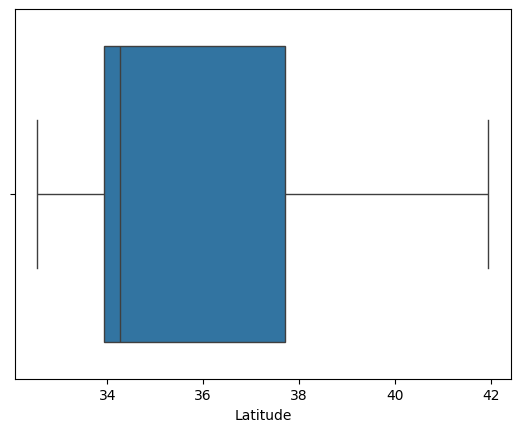

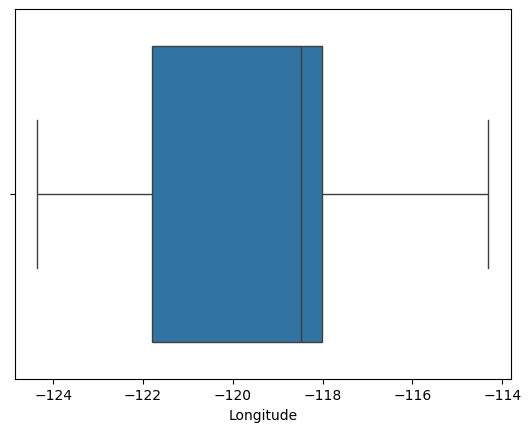

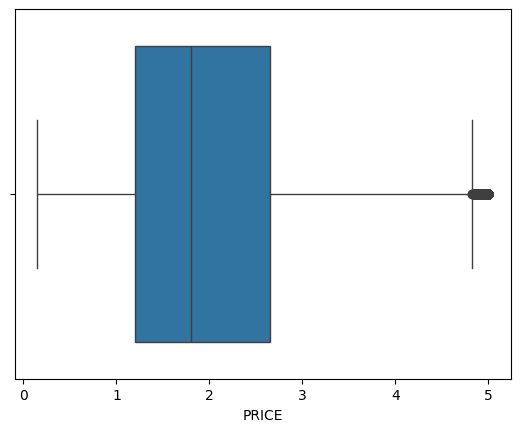

In [16]:
# ------ Outliers ------------

for col in hpdata.columns:
    sns.boxplot(x=hpdata[col])
    plt.show()
    plt.title(f"Boxplot of {col}")
    plt.savefig(os.path.join('eda_outputs', f"box_{col}.png"))
    plt.close()

## Train Test Validation split

In [17]:

X = hpdata.drop(columns=["PRICE"])
y = hpdata["PRICE"]

# Train/Validation/Test split (already done, but showing for clarity)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print("Train:", X_train.shape, "Validation:", X_valid.shape, "Test:", X_test.shape)

Train: (14448, 8) Validation: (3096, 8) Test: (3096, 8)


In [18]:
# --------------- Checking for multicollinearity -------------


import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

def compute_vif(X):
    X_const = sm.add_constant(X)
    vif = pd.Series([variance_inflation_factor(X_const.values, i+1)  # skip const index 0
                     for i in range(X.shape[1])], index=X.columns)
    return vif.sort_values(ascending=False)

vif_train = compute_vif(X_train)
print(vif_train)


Latitude      9.082216
Longitude     8.756344
AveRooms      8.212640
AveBedrms     6.933448
MedInc        2.495988
HouseAge      1.236715
Population    1.135696
AveOccup      1.010777
dtype: float64


# Models evaluation

In [19]:
!pip install --upgrade scikit-learn -q

In [20]:
def evaluate_and_log(model, model_name, X_train, y_train, X_val, y_val):
    with mlflow.start_run(run_name=model_name):
        # Fit
        model.fit(X_train, y_train)

        # Predict & evaluate
        preds = model.predict(X_val) 
        rmse = mean_squared_error(y_val, preds) ** 0.5
        r2 = r2_score(y_val, preds)

        # Log params, metrics
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)

        # Log model artifact
        mlflow.sklearn.log_model(model, artifact_path="model")

        print(f"{model_name}: RMSE={rmse:.4f}, R2={r2:.4f}")

In [23]:
def evaluate_and_log(model, model_name, X_train, y_train, X_val, y_val):
    with mlflow.start_run(run_name=model_name):
        # Fit
        model.fit(X_train, y_train)

        # Predict & evaluate
        preds = model.predict(X_val) 
        rmse = mean_squared_error(y_val, preds) ** 0.5
        r2 = r2_score(y_val, preds)

        # Log params, metrics
        if hasattr(model, "get_params"):
            mlflow.log_params(model.get_params())
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)

        # Log model artifact
        mlflow.sklearn.log_model(model, artifact_path="model")

        print(f"{model_name}: RMSE={rmse:.4f}, R2={r2:.4f}")

        # ✅ Return model info so it can be stored in results
        return {"name": model_name, "rmse": rmse, "r2": r2, "model": model}


def main(X_train, y_train, X_val, y_val):
    mlflow.set_experiment("house_price_comparison")
    results = []

    # 1. Random Forest (raw features)
    rf = RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    )
    results.append(evaluate_and_log(rf, "RandomForest", X_train, y_train, X_val, y_val))

    # 2. SVM (with RobustScaler)
    svm_pipeline = Pipeline([
        ("scaler", RobustScaler()),
        ("svm", SVR(C=10, epsilon=0.2, kernel="rbf"))
    ])
    results.append(evaluate_and_log(svm_pipeline, "SVM_RobustScaled", X_train, y_train, X_val, y_val))

    # 3. RidgeCV with RobustScaler
    ridge_pipeline = Pipeline([
        ("scaler", RobustScaler()),
        ("ridge", RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
    ])
    results.append(evaluate_and_log(ridge_pipeline, "RidgeCV_RobustScaled", X_train, y_train, X_val, y_val))


    # -------------------------
    # Pick Best Model
    # -------------------------
    best_run = min(results, key=lambda x: x["rmse"])
    print(f"\n✅ Best Model: {best_run['name']} with RMSE={best_run['rmse']:.4f}")

    # Save best model as joblib
    os.makedirs("models", exist_ok=True)
    best_model_path = f"models/best_model_{best_run['name']}.joblib"
    joblib.dump(best_run["model"], best_model_path)
    print(f"💾 Saved best model to {best_model_path}")

    return best_run


best_run = main(X_train, y_train, X_valid, y_valid)


2025/10/03 22:34:21 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 22:34:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomForest: RMSE=0.5336, R2=0.7814


2025/10/03 22:34:53 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 22:35:03 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


SVM_RobustScaled: RMSE=0.6432, R2=0.6825


2025/10/03 22:35:04 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/10/03 22:35:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RidgeCV_RobustScaled: RMSE=0.7354, R2=0.5848

✅ Best Model: RandomForest with RMSE=0.5336
💾 Saved best model to models/best_model_RandomForest.joblib


In [24]:
best_run

{'name': 'RandomForest',
 'rmse': 0.5336417470196814,
 'r2': 0.7814088431676594,
 'model': RandomForestRegressor(max_depth=12, n_estimators=200, n_jobs=-1,
                       random_state=42)}

# Selecting Best fit model

# Testing joblib model

In [26]:
loaded_model = joblib.load("models/best_model.joblib")

# make predictions
y_pred = loaded_model.predict(X_test)
y_pred

array([1.38617902, 0.80629296, 2.0390147 , ..., 0.91972069, 1.65764511,
       2.57489555], shape=(3096,))

# Deply in FastAPI

In [27]:
!pip install fastapi uvicorn  -q

In [ ]:
from fastapi import FastAPI
from pydantic import BaseModel
import joblib

# Load model
model = joblib.load("models/best_model.joblib")  # path to your saved model

# Define request schema
class InputData(BaseModel):
    features: dict   # flexible dict input


# Create FastAPI instance
app = FastAPI()

@app.get("/")
def root():
    return {"message": "House Price Prediction API is running!"}

@app.post("/predict")
def predict(data: InputData):
    # Convert Pydantic model -> dict
    input_dict = data.dict()["features"]   # <-- FIX here

    # Convert dict -> DataFrame
    X = pd.DataFrame([input_dict])   # one row only

    # Predict
    prediction = model.predict(X)
    return {"prediction": float(prediction[0])}


## Run API